# <center> Process of cleaning and analyzing horse racing data from Kaggle dataset "Horses for Courses"</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare, ttest_ind, zscore

%matplotlib inline

#Supresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#There are a lot of issues with the 'position_two' column, so I left it out.
#Furthermore, the 'position_again' column is much more consistent and has all relevant win/place information  

fields = ["position_again","bf_odds","venue_name","date","market_name","condition",
          "barrier","handicap_weight","last_five_starts","prize_money","sex",
          "age","jockey_sex","days_since_last_run","overall_starts","overall_wins",
          "overall_places","track_starts","track_wins","track_places","firm_starts",
          "firm_wins","firm_places","good_starts","good_wins","good_places",
          "slow_starts","slow_wins","slow_places","soft_starts","soft_wins",
          "soft_places","heavy_starts","heavy_wins","heavy_places","distance_starts",
          "distance_wins","distance_places"]

#May use "jockey","trainer" later

df = pd.read_csv("horses.csv", usecols=fields, skipinitialspace=True, low_memory=False)

df.head()

,position_again,bf_odds,venue_name,date,market_name,condition,barrier,handicap_weight,last_five_starts,prize_money,...,slow_places,soft_starts,soft_wins,soft_places,heavy_starts,heavy_wins,heavy_places,distance_starts,distance_wins,distance_places
0,1.00,2.88,Echuca,2016-06-27,R3 1200m Mdn,HVY9,3.00,58.50,f3,2160.00,...,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
1,2.00,15.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,10.00,58.50,x80x2,21175.00,...,1.00,2.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00
2,3.00,95.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,6.00,56.50,79x00,28855.00,...,0.00,5.00,0.00,0.00,3.00,0.00,0.00,4.00,0.00,0.00
3,nan,20.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,2.00,56.50,f0,1475.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,nan,2.74,Echuca,2016-06-27,R3 1200m Mdn,HVY9,7.00,56.50,f4x,1215.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [3]:
df.date = pd.to_datetime(df.date, format='%Y'+'-'+'%m'+'-'+'%d')

#removes numbers from end of 'condition' strings
df.condition = df.condition.str.replace('\d+', '')

#renaming condition values so that they're uniform
df.condition = df.condition.replace(['HVY','AWT'], ['HEAVY','GOOD']) 
#AWT equates to a Good surface under some weather conditions

#reverses 'last_five_starts' (originally written right-to-left) 
#so that it's easier to read in the future
df.last_five_starts = df.last_five_starts.str[::-1]

## Useful Functions:

In [4]:
def column_cleaner(cleaned_df, grouped_df, column_name):
    non_null_indices = grouped_df[column_name].apply(lambda x: all(x.notnull()))
    
    non_null_df = cleaned_df[non_null_indices]
    
    non_null_grouped = non_null_df.groupby(['date','venue_name','market_name'])
    
    clean_indices = non_null_grouped[column_name].value_counts(normalize=True,dropna=False).\
        where(lambda x:x != 1).dropna().index.droplevel(column_name)
    
    new_cleaned_df = non_null_df.loc[clean_indices].drop_duplicates()
    return new_cleaned_df

def cleaned_win_df(cleaned_df):
    win_indices = cleaned_df.position_again.apply(lambda x:x == 1)
    
    df_cleaned_win = cleaned_df[win_indices]
    return df_cleaned_win

# Creating new features and dropping others in order to relate horses in each race to one another while allowing the general input of the dataset into a machine learning model:

## Creating a distance column from market_name:

In [5]:
new = df.market_name.str.split(expand=True)

df['distance'] = new[1].str.rstrip('m')

df.distance.head()

0    1200
1    1200
2    1200
3    1200
4    1200
Name: distance, dtype: object

## Creating general and track, distance, condition-specific 'win_percent' and 'place_percent' columns:

In [6]:
#creates overall, track, and distance win_percent and place_percent columns
#and drops existing wins and places columns

columns_list = ["overall","track","distance"]

for x in columns_list:
    df[x+"_win_percent"] = df[x+"_wins"]/df[x+"_starts"]
    
    df[x+"_place_percent"] = df[x+"_places"]/df[x+"_starts"]

    # dropping various columns, though 'starts' columns will be used later
    df.drop([x+'_wins', x+'_places'], axis=1, inplace=True)

In [7]:
#creates a condition_starts ,condition_win_percent, and condition_place_percent column
#for each horse according to the condition of the track for that race

df.loc[df.condition.isna(), "condition_win_percent"] = np.nan

condition_list = ["firm","good","slow","soft","heavy"]

for x in condition_list: 
    df.loc[df.condition.str.lower() == x, "condition_starts"] = df[x+"_starts"]
    
    df.loc[df.condition.str.lower() == x, "condition_win_percent"] = df[x+"_wins"]/df[x+"_starts"]
    
    df.loc[df.condition.str.lower() == x, "condition_place_percent"] = df[x+"_places"]/df[x+"_starts"]
    
    df.drop([x+'_starts', x+'_wins', x+'_places'], axis=1, inplace=True)

# Replaces infinity (zero division) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

## Find and drop features that are primarily NaN:

In [8]:
df.isnull().sum()
#The position_again is primarily nan values because it only shows first and place
#However, track_starts is primarily zeros, so the track_win/place_percent columns are nan

position_again             158461
bf_odds                         0
venue_name                      0
date                            0
market_name                     0
condition                   22188
barrier                     26289
handicap_weight             26289
last_five_starts            36949
prize_money                 26791
sex                         26791
age                         26791
jockey_sex                  26791
days_since_last_run         27042
overall_starts              27042
track_starts                27042
distance_starts             27042
distance                        0
overall_win_percent         37647
overall_place_percent       37647
track_win_percent          108448
track_place_percent        108448
distance_win_percent        55956
distance_place_percent      55956
condition_win_percent       57116
condition_starts            29806
condition_place_percent     57116
dtype: int64

In [9]:
df.drop(['track_win_percent','track_place_percent'],axis=1,inplace=True)

In [10]:
#position_again unique values
df.position_again.unique()

array([ 1.,  2.,  3., nan,  5.,  4.])

## Splits last_five_starts column into 5 separate columns, replaces values, then drops last_five_starts:

In [11]:
new = pd.DataFrame()

for i in range(5):
    new[i] = df.last_five_starts.str[i:i+1]

for i in range(5):
    df['last_start'+str(i+1)] = new[i].replace(['','x','f'],[np.nan,'scratch','fell'])    
'''
for i in range(5):
    df['last_start'+str(i+1)] = new[i].replace(['','x','f',0],[np.nan,50,100,10])
'''
df.drop('last_five_starts',axis=1,inplace=True)

## Cleaning data by removing races with missing win and/or place values in 'position_again' column:

In [12]:
#Used groupby to create indices by which to sort the re-indexed dataframes below, like df_indexed and df_cleaned
df_grouped = df.groupby(['date','venue_name','market_name'])

#Drops all groups/races in 'position_again' column where sum of values [1st, 2nd, 3rd] don't add to 3 or 6
#i.e. 1+2 and 1+2+3
index_list1 = df_grouped.position_again.sum(dropna=False).where(lambda x:(x == 3) | (x == 6)).dropna().index

df_indexed = df.set_index(['date','venue_name','market_name'])

df_cleaned = df_indexed.loc[index_list1].drop_duplicates()

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

#Eliminates remaining errors in 'position_again' column by making sure that there isn't a single 3rd-place finish
index_list2 = df_grouped.position_again.value_counts(normalize=True,dropna=False)\
    .where(lambda x:x != 1).dropna().index.droplevel('position_again')

df_cleaned = df_cleaned.loc[index_list2].drop_duplicates()

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

## Creating a weight_z column:

In [13]:
df_cleaned['weight_z'] = df_grouped['handicap_weight'].transform(lambda x: zscore(x,ddof=1))

df_cleaned.drop('handicap_weight',axis=1,inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

## Creating a prize_money_per_start_z column:

### This may be one of the best indicators, as prize money is also an indicator of the difficulty of past races. Therefore, the value (meaningfulness) of past wins is taken into consideration.

In [14]:
#creates prize_money_per_start column
df_cleaned['prize_money_per_start'] = df_cleaned.prize_money/df_cleaned.overall_starts

df_cleaned['prize_money_per_start_z'] = df_grouped['prize_money_per_start']\
    .transform(lambda x: zscore(x,ddof=1))

df_cleaned.drop(['prize_money','prize_money_per_start'],axis=1,inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

## Creating a horse age_z column:

In [15]:
df_cleaned['age_z'] = df_grouped['age'].transform(lambda x: zscore(x,ddof=1))

df_cleaned.drop('age',axis=1,inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

## Creating race-relative z-scores for the remaining continuous features:

In [16]:
z_score_cols = ['days_since_last_run','overall_win_percent','overall_place_percent',
                'distance_win_percent','distance_place_percent','condition_win_percent',
                'condition_place_percent','overall_starts','distance_starts','condition_starts',
                'track_starts']

for col in z_score_cols:
    df_cleaned[col+'_z'] = df_grouped[col].transform(lambda x: zscore(x,ddof=1))
    
    if (col == 'overall_starts')|(col == 'distance_starts')|(col == 'condition_starts')|(col == 'track_starts'):
        pass
    else:    
        df_cleaned.drop(col,axis=1,inplace=True)

In [17]:
#Replaces infinity (zero division) with NaN
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

df_cleaned.head()

position_again  bf_odds condition  \
date       venue_name market_name                                         
2016-06-27 Echuca     R10 1400m Hcap            1.00    18.50     HEAVY   
                      R10 1400m Hcap            2.00    16.50     HEAVY   
                      R10 1400m Hcap            3.00    11.50     HEAVY   
                      R10 1400m Hcap             nan    19.00     HEAVY   
                      R10 1400m Hcap             nan     7.60     HEAVY   

                                      barrier      sex jockey_sex  \
date       venue_name market_name                                   
2016-06-27 Echuca     R10 1400m Hcap    12.00     Mare       Male   
                      R10 1400m Hcap     8.00  Gelding       Male   
                      R10 1400m Hcap     1.00  Gelding       Male   
                      R10 1400m Hcap     5.00  Gelding       Male   
                      R10 1400m Hcap     7.00     Mare       Male   

                                      overall_starts  track_starts  \
date       venue_name market_name                                    
2016-06-27 Echuca     R10 1400m Hcap           26.00         10.00   
                      R10 1400m Hcap           12.00          1.00   
                      R10 1400m Hcap           20.00          7.00   
                      R10 1400m Hcap           31.00          2.00   
                      R10 1400m Hcap            6.00          0.00   

                                      distance_starts distance  ...  \
date       venue_name market_name                               ...   
2016-06-27 Echuca     R10 1400m Hcap            12.00     1400  ...   
                      R10 1400m Hcap             9.00     1400  ...   
                      R10 1400m Hcap            10.00     1400  ...   
                      R10 1400m Hcap            16.00     1400  ...   
                      R10 1400m Hcap             3.00     1400  ...   

                                      overall_win_percent_z  \
date       venue_name market_name                             
2016-06-27 Echuca     R10 1400m Hcap                  -0.09   
                      R10 1400m Hcap                   0.06   
                      R10 1400m Hcap                  -0.72   
                      R10 1400m Hcap                  -0.76   
                      R10 1400m Hcap                   2.00   

                                     overall_place_percent_z  \
date       venue_name market_name                              
2016-06-27 Echuca     R10 1400m Hcap                   -0.24   
                      R10 1400m Hcap                   -0.12   
                      R10 1400m Hcap                    1.19   
                      R10 1400m Hcap                   -0.17   
                      R10 1400m Hcap                    1.52   

                                     distance_win_percent_z  \
date       venue_name market_name                             
2016-06-27 Echuca     R10 1400m Hcap                   0.19   
                      R10 1400m Hcap                   0.09   
                      R10 1400m Hcap                   0.01   
                      R10 1400m Hcap                  -0.04   
                      R10 1400m Hcap                   0.50   

                                     distance_place_percent_z  \
date       venue_name market_name                               
2016-06-27 Echuca     R10 1400m Hcap                     0.50   
                      R10 1400m Hcap                     0.28   
                      R10 1400m Hcap                     0.89   
                      R10 1400m Hcap                     0.01   
                      R10 1400m Hcap                     1.15   

                                     condition_win_percent_z  \
date       venue_name market_name                              
2016-06-27 Echuca     R10 1400m Hcap                     nan   
                      R10 1400m Hcap                     n

## Cleaned Dataframe Details:

In [18]:
df_cleaned.shape

(205247, 30)

In [19]:
len(df_grouped) #Number of remaining races

21589

# Testing which features are significant:

## For horse gender:

In [20]:
#Removes races where only one horse gender is represented
sex_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'sex')

sex_pop_cleaned_win = cleaned_win_df(sex_pop_cleaned)

In [21]:
#General percentage of horse genders for races where multiple genders are represented  
sex_pop_cleaned.sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False)\
    .drop('Unknown')

Gelding   0.57
Mare      0.27
Filly     0.13
Colt      0.03
Horse     0.01
Name: sex, dtype: float64

In [22]:
sex_pop_cleaned_win.sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False)\
    .drop('Unknown')

Gelding   0.57
Mare      0.24
Filly     0.14
Colt      0.04
Horse     0.01
Name: sex, dtype: float64

In [23]:
horse_sex_pop = sex_pop_cleaned.sex.value_counts(dropna=False,normalize=True)\
    .sort_values(ascending=False).drop('Unknown')

horse_sex_win = sex_pop_cleaned_win.sex.value_counts(dropna=False,normalize=True)\
    .sort_values(ascending=False).drop('Unknown')

horse_sex_percent_difference = (horse_sex_win - horse_sex_pop)/horse_sex_pop

horse_sex_percent_difference

Gelding    0.00
Mare      -0.11
Filly      0.10
Colt       0.49
Horse      0.16
Name: sex, dtype: float64

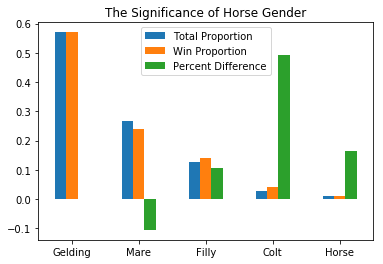

In [24]:
index1 = ['Gelding', 'Mare', 'Filly','Colt', 'Horse']

df1 = pd.DataFrame({'Total Proportion': horse_sex_pop,'Win Proportion': horse_sex_win ,
                    'Percent Difference': horse_sex_percent_difference}, index=index1)

ax = df1.plot.bar(rot=0,title='The Significance of Horse Gender')

### Using the Pearson's chi-squared, I find horse gender is significant:

In [25]:
observed1 = sex_pop_cleaned_win.sex.value_counts().sort_values(ascending=False)\
    .drop('Unknown').values

expected_percentages1 = horse_sex_pop.values
expected1 = [x*observed1.sum() for x in expected_percentages1]

test_stat1, p_value1 = chisquare(observed1, expected1)

test_stat1, p_value1

(196.24429401115708, 2.4113691661853285e-41)

## For horse age_z (z-scores):

In [26]:
#Removing races where there is only one age
age_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'age_z')

age_pop_cleaned_win = cleaned_win_df(age_pop_cleaned)

In [27]:
age_pop_cleaned.age_z.describe()

count   173889.00
mean         0.00
std          0.95
min         -3.33
25%         -0.71
50%         -0.17
75%          0.63
max          3.88
Name: age_z, dtype: float64

In [28]:
age_pop_cleaned_win.age_z.describe()

count   17428.00
mean       -0.24
std         0.88
min        -3.33
25%        -0.86
50%        -0.41
75%         0.30
max         3.61
Name: age_z, dtype: float64

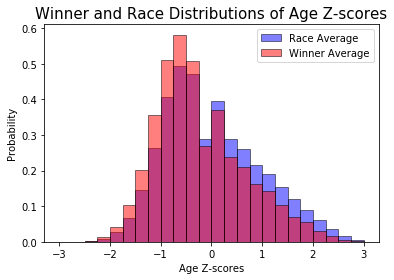

In [29]:
data2a = age_pop_cleaned.age_z.dropna().values

data2b = age_pop_cleaned_win.age_z.dropna().values

plt.title("Winner and Race Distributions of Age Z-scores", fontsize=15)

plt.hist(data2a, density=True, bins=24, range=(-3,3), label='Race Average', 
         color='b', alpha=.5, edgecolor='k')

plt.hist(data2b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Age Z-scores')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that Age Z-scores is significant:

In [30]:
test_stat2, p_value2 = ttest_ind(data2a, data2b)

test_stat2, p_value2

(31.555501940416974, 5.495528873695373e-218)

## For horse handicap weight_z (z-scores):

In [31]:
#Removing races where there is only one age
weight_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'weight_z')

weight_pop_cleaned_win = cleaned_win_df(weight_pop_cleaned)

In [32]:
weight_pop_cleaned.weight_z.describe()

count   188773.00
mean        -0.00
std          0.95
min         -3.88
25%         -0.75
50%         -0.06
75%          0.74
max          3.95
Name: weight_z, dtype: float64

In [33]:
weight_pop_cleaned_win.weight_z.describe()

count   19069.00
mean        0.21
std         0.95
min        -3.88
25%        -0.57
50%         0.27
75%         0.90
max         3.53
Name: weight_z, dtype: float64

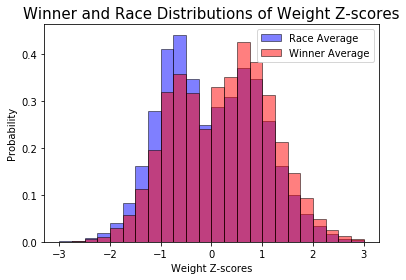

In [34]:
data3a = weight_pop_cleaned.weight_z.dropna().values

data3b = weight_pop_cleaned_win.weight_z.dropna().values

plt.title("Winner and Race Distributions of Weight Z-scores", fontsize=15)

plt.hist(data3a, density=True, bins=24, range=(-3,3), label='Race Average', 
         color='b', alpha=.5, edgecolor='k')

plt.hist(data3b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Weight Z-scores')
plt.ylabel('Probability');

### Using a 2-sample T-test, again I find that Weight Z-scores is significant:

In [35]:
test_stat3, p_value3 = ttest_ind(data3a, data3b)

test_stat3, p_value3

(-28.822130207835215, 2.5976728545751035e-182)

## For prize money, using prize_money_per_start_z (z-scores):

In [36]:
money_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'prize_money_per_start_z')

money_pop_cleaned_win = cleaned_win_df(weight_pop_cleaned)

In [37]:
money_pop_cleaned.prize_money_per_start_z.describe()

count   150865.00
mean         0.00
std          0.95
min         -2.82
25%         -0.66
50%         -0.24
75%          0.49
max          3.84
Name: prize_money_per_start_z, dtype: float64

In [38]:
#Winner prize money 
money_pop_cleaned_win.prize_money_per_start_z.describe()

count   15197.00
mean        0.62
std         1.04
min        -2.13
25%        -0.22
50%         0.46
75%         1.40
max         3.83
Name: prize_money_per_start_z, dtype: float64

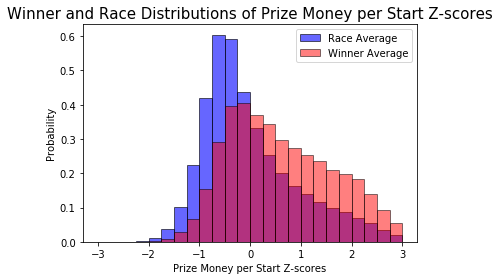

In [39]:
data4a = money_pop_cleaned.prize_money_per_start_z.dropna().values
data4b = money_pop_cleaned_win.prize_money_per_start_z.dropna().values

plt.title("Winner and Race Distributions of Prize Money per Start Z-scores",
          fontsize=15)

plt.hist(data4a, density=True, bins=24, range=(-3,3), label='Race Average',
         color='b', alpha=.6, edgecolor='k')

plt.hist(data4b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Prize Money per Start Z-scores')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that Prize Money per Start Z-scores is significant:


In [40]:
test_stat4, p_value4 = ttest_ind(data4a, data4b)

test_stat4, p_value4

(-76.41990201705845, 0.0)

## For overall wins:

In [41]:
overall_win_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'overall_win_percent_z')

overall_win_pop_cleaned_win = cleaned_win_df(overall_win_pop_cleaned)

In [42]:
overall_win_pop_cleaned.overall_win_percent_z.describe()

count   129668.00
mean         0.00
std          0.95
min         -2.66
25%         -0.66
50%         -0.21
75%          0.53
max          3.75
Name: overall_win_percent_z, dtype: float64

In [43]:
overall_win_pop_cleaned_win.overall_win_percent_z.describe()

count   13167.00
mean        0.31
std         1.02
min        -2.65
25%        -0.46
50%         0.13
75%         1.01
max         3.59
Name: overall_win_percent_z, dtype: float64

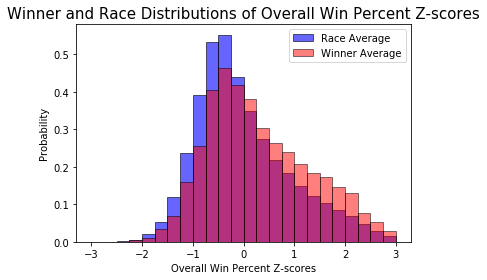

In [44]:
data5a = overall_win_pop_cleaned.overall_win_percent_z.dropna().values
data5b = overall_win_pop_cleaned_win.overall_win_percent_z.dropna().values

plt.title("Winner and Race Distributions of Overall Win Percent Z-scores",
          fontsize=15)

plt.hist(data5a, density=True, bins=24, range=(-3,3), label='Race Average',
         color='b', alpha=.6, edgecolor='k')

plt.hist(data5b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Overall Win Percent Z-scores')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that Overall Win Percent Z-scores is significant:

In [45]:
test_stat5, p_value5 = ttest_ind(data5a, data5b)

test_stat5, p_value5

(-35.60594650187907, 1.8659451269816977e-276)

### There is high variance in the 100% column (aka beginner's luck). How many races before the 100% column is properly represented? That is, how many races is considered statistically significant?

### It seems that a minimum of 5 races for all horses in the race gives the percent difference bar graph an exponential appearance.

In [46]:
overall_win_pop_grouped = overall_win_pop_cleaned.groupby(['date','venue_name',
                                                           'market_name'])

overall_starts_indices = overall_win_pop_grouped.overall_starts.agg('min')\
    .where(lambda x:x >= 5).dropna().index

overall_starts_cleaned = overall_win_pop_cleaned.loc[overall_starts_indices].drop_duplicates()

overall_starts_cleaned_win = cleaned_win_df(overall_starts_cleaned)

In [47]:
overall_starts_cleaned.overall_win_percent_z.describe()

count   85608.00
mean        0.00
std         0.95
min        -2.66
25%        -0.69
50%        -0.15
75%         0.59
max         3.40
Name: overall_win_percent_z, dtype: float64

In [48]:
overall_starts_cleaned_win.overall_win_percent_z.describe()

count   8806.00
mean       0.30
std        1.00
min       -2.65
25%       -0.46
50%        0.18
75%        1.01
max        3.40
Name: overall_win_percent_z, dtype: float64

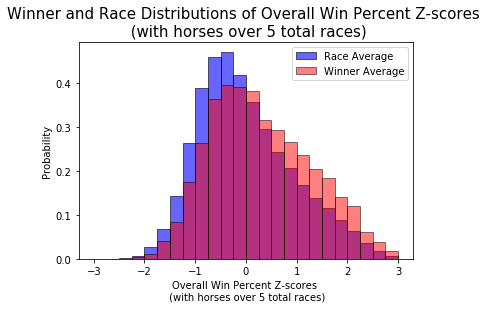

In [49]:
data6a = overall_starts_cleaned.overall_win_percent_z.dropna().values
data6b = overall_starts_cleaned_win.overall_win_percent_z.dropna().values

plt.title("Winner and Race Distributions of Overall Win Percent Z-scores \n (with horses over 5 total races)",
          fontsize=15)

plt.hist(data6a, density=True, bins=24, range=(-3,3), label='Race Average',
         color='b', alpha=.6, edgecolor='k')

plt.hist(data6b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Overall Win Percent Z-scores \n (with horses over 5 total races)')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that Overall Win Percent Z-scores (with horses over 5 total races) is significant:

In [50]:
test_stat6, p_value6 = ttest_ind(data6a, data6b)

test_stat6, p_value6

(-28.057312959704664, 1.6702355295015772e-172)

## For Barrier:

In [51]:
barrier_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'barrier')

barrier_grouped = barrier_pop_cleaned.groupby(['date','venue_name','market_name'])

barrier_indices = barrier_grouped.barrier.value_counts().where(lambda x:x == 1)\
    .dropna().index.droplevel('barrier')

barrier_pop_cleaned = barrier_pop_cleaned.loc[barrier_indices]

barrier_pop_cleaned_win = cleaned_win_df(barrier_pop_cleaned)

In [52]:
barrier_pop = barrier_pop_cleaned.barrier.value_counts(normalize=True).sort_index()\
    .drop([18.00,19.00,20.00])

barrier_win = barrier_pop_cleaned_win.barrier.value_counts(normalize=True).sort_index()\
    .drop(18.00)

barrier_percent_difference = (barrier_win - barrier_pop)/barrier_pop

In [53]:
barrier_percent_difference

1.00     0.22
2.00     0.03
3.00     0.05
4.00     0.09
5.00     0.12
6.00     0.12
7.00    -0.02
8.00    -0.10
9.00    -0.11
10.00   -0.16
11.00   -0.19
12.00   -0.19
13.00   -0.35
14.00   -0.36
15.00   -0.13
16.00   -0.39
17.00   -0.15
Name: barrier, dtype: float64

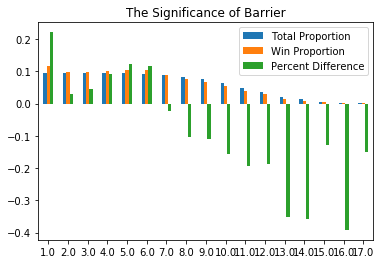

In [54]:
index7 = barrier_percent_difference.index

df7 = pd.DataFrame({'Total Proportion': barrier_pop,'Win Proportion': barrier_win ,
                    'Percent Difference': barrier_percent_difference}, index=index7)

ax = df7.plot.bar(rot=0, title='The Significance of Barrier')

### Why is barrier 1 so overrepresented? Is there a problem with the data? There doesn't appear to be.

### Using the Pearson's chi-squared test, I find that barrier is significant:

In [55]:
observed7 = barrier_pop_cleaned_win.barrier.value_counts().sort_index().drop(18.00).values
expected_percentages7 = barrier_pop.values
expected7 = [x*observed7.sum() for x in expected_percentages7]

test_stat7, p_value7 = chisquare(observed7, expected7)

test_stat7, p_value7

(3749.5577711230185, 0.0)

## For jockey gender: 

#### Overall percentage of men and women in races where both are represented:

In [56]:
#Drops races where there is only one jockey gender, meaning that the other gender can't win
jockey_sex_cleaned = column_cleaner(df_cleaned, df_grouped, 'jockey_sex')

jockey_sex_cleaned_win = cleaned_win_df(jockey_sex_cleaned)

#### Finding the total a different way:

In [57]:
jockey_sex_cleaned.jockey_sex.value_counts(normalize=True)
#This amount is the sum of all 'male' and 'female' jockeys added together and THEN 'normalized'

Male     0.75
Female   0.25
Name: jockey_sex, dtype: float64

#### Win percentage of those races:

In [58]:
#Isolates wins in races with both jockey genders represented
jockey_sex_cleaned_win.jockey_sex.value_counts(normalize=True, dropna=False)

Male     0.79
Female   0.21
Name: jockey_sex, dtype: float64

In [59]:
#Finding the percent difference between win and total
jockey_sex_pop = jockey_sex_cleaned.jockey_sex.value_counts(normalize=True,
                                                            dropna=False).values

jockey_sex_win = jockey_sex_cleaned_win.jockey_sex.value_counts(normalize=True,
                                                                dropna=False).values

jockey_sex_percent_difference = (jockey_sex_win - jockey_sex_pop)/jockey_sex_pop

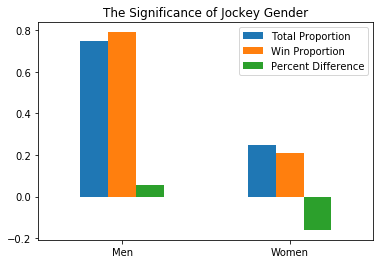

In [60]:
index6 = ['Men','Women']

df6 = pd.DataFrame({'Total Proportion': jockey_sex_pop,'Win Proportion': jockey_sex_win ,
                    'Percent Difference': jockey_sex_percent_difference}, index=index6)

ax = df6.plot.bar(rot=0, title='The Significance of Jockey Gender')

### Using a 2-proportion z-test, I find that jockey gender is significant with a p-value of 2.3E-30
#### (There is currently a bug with the statsmodels library concering compatibility with scipy, so I used a scientific calculator)

# How often would you win and what would be your expected return if you always bet on the favorite?

In [61]:
odds_cleaned = column_cleaner(df_cleaned, df_grouped, 'bf_odds')

In [62]:
#creates dataframe with a unique index
odds_cleaned['uniq_idx'] = range(len(odds_cleaned))
odds_cleaned_uniq_idx = odds_cleaned.set_index('uniq_idx',append=True)
uniq_idx_grouped = odds_cleaned_uniq_idx.groupby(['date','venue_name',
                                                  'market_name'])

odds_cleaned_uniq_idx.head()

position_again  bf_odds  \
date       venue_name market_name    uniq_idx                            
2016-06-27 Echuca     R10 1400m Hcap 0                   1.00    18.50   
                                     1                   2.00    16.50   
                                     2                   3.00    11.50   
                                     3                    nan    19.00   
                                     4                    nan     7.60   

                                              condition  barrier      sex  \
date       venue_name market_name    uniq_idx                               
2016-06-27 Echuca     R10 1400m Hcap 0            HEAVY    12.00     Mare   
                                     1            HEAVY     8.00  Gelding   
                                     2            HEAVY     1.00  Gelding   
                                     3            HEAVY     5.00  Gelding   
                                     4            HEAVY     7.00     Mare   

                                              jockey_sex  overall_starts  \
date       venue_name market_name    uniq_idx                              
2016-06-27 Echuca     R10 1400m Hcap 0              Male           26.00   
                                     1              Male           12.00   
                                     2              Male           20.00   
                                     3              Male           31.00   
                                     4              Male            6.00   

                                               track_starts  distance_starts  \
date       venue_name market_name    uniq_idx                                  
2016-06-27 Echuca     R10 1400m Hcap 0                10.00            12.00   
                                     1                 1.00             9.00   
                                     2                 7.00            10.00   
                                     3                 2.00            16.00   
                                     4                 0.00             3.00   

                                              distance  ...  \
date       venue_name market_name    uniq_idx           ...   
2016-06-27 Echuca     R10 1400m Hcap 0            1400  ...   
                                     1            1400  ...   
                                     2            1400  ...   
                                     3            1400  ...   
                                     4            1400  ...   

                                               overall_win_percent_z  \
date       venue_name market_name    uniq_idx                          
2016-06-27 Echuca     R10 1400m Hcap 0                         -0.09   
                                     1                          0.06   
                                     2                         -0.72   
                                     3                         -0.76   
                                     4                          2.00   

                                              overall_place_percent_z  \
date       venue_name market_name    uniq_idx                           
2016-06-27 Echuca     R10 1400m Hcap 0                          -0.24   
                                     1                          -0.12   
                                     2                           1.19   
                                     3                          -0.17   
                                     4                           1.52   

                                              distance_win_percent_z  \
date       venue_name market_name    uniq_idx                          
2016-06-27 Echuca     R10 1400m Hcap 0                          0.19   
                                     1                          0.09   
                                     2                          0.01   
                                     3                         -0.04   
   

In [63]:
average = uniq_idx_grouped.bf_odds.agg('min').mean()

In [64]:
bf_min_indices = uniq_idx_grouped.bf_odds.idxmin
    
min_odds_cleaned = odds_cleaned_uniq_idx.loc[bf_min_indices].drop_duplicates()

min_odds_win = cleaned_win_df(min_odds_cleaned)

odds_pop = len(min_odds_cleaned)
odds_win = len(min_odds_win)

print(len(min_odds_cleaned))
print(len(min_odds_win))

21587
7410


### How often the favorite wins:

In [65]:
odds_win/odds_pop

0.3432621485153101

### The expected return if betting 1 dollar on favorite every race:

In [66]:
-1*(1-odds_win/odds_pop) + average*odds_win/odds_pop

0.4850895692342706

# Beginning the Machine Learning Process:

In [67]:
df_cleaned.drop(['condition_place_percent_z','condition_win_percent_z',
                 'distance_place_percent_z','distance_win_percent_z'],
                axis=1,inplace=True)

In [68]:
#Modifying categorical groups
df_cleaned.reset_index(drop=True,inplace=True)

df_cleaned_test = df_cleaned.copy()

df_cleaned_test.position_again = df_cleaned_test.position_again.replace([2,3,np.nan],
                                                                        [0,0,0])

In [69]:
categorical_list = ['sex','jockey_sex','condition','barrier','last_start1',
             'last_start2','last_start3','last_start4','last_start5']
df_cleaned_test = pd.get_dummies(df_cleaned_test,columns=categorical_list,drop_first=True,dummy_na=1)

In [70]:
df_cleaned_test.head()

,position_again,bf_odds,overall_starts,track_starts,distance_starts,distance,condition_starts,weight_z,prize_money_per_start_z,age_z,...,last_start5_3,last_start5_4,last_start5_5,last_start5_6,last_start5_7,last_start5_8,last_start5_9,last_start5_fell,last_start5_scratch,last_start5_nan
0,1.00,18.50,26.00,10.00,12.00,1400,4.00,-0.67,-0.66,0.11,...,0,0,0,0,0,0,0,0,0,0
1,0.00,16.50,12.00,1.00,9.00,1400,2.00,0.97,-0.60,-0.58,...,0,0,0,0,0,0,0,0,1,0
2,0.00,11.50,20.00,7.00,10.00,1400,1.00,0.42,-0.64,-0.58,...,0,0,1,0,0,0,0,0,0,0
3,0.00,19.00,31.00,2.00,16.00,1400,1.00,0.42,0.42,0.11,...,0,0,0,0,0,0,0,0,0,0
4,0.00,7.60,6.00,0.00,3.00,1400,0.00,0.42,0.37,-1.26,...,1,0,0,0,0,0,0,0,0,0


In [71]:

'''
df_cleaned_test.sex = df_cleaned_test.sex.replace(['Gelding','Mare','Filly',
                                                   'Colt','Horse','Unknown',
                                                   np.nan],[0,1,2,3,4,5,6])

df_cleaned_test.jockey_sex = df_cleaned_test.jockey_sex.replace(['Male','Female'], 
                                                                [0, 1])
'''

'''
df_cleaned_test.condition = df_cleaned_test.condition.replace(['HEAVY','GOOD','SOFT','FIRM',np.nan],
                                                              [0, 1, 2, 3, 4])
'''


"\ndf_cleaned_test.condition = df_cleaned_test.condition.replace(['HEAVY','GOOD','SOFT','FIRM',np.nan],\n                                                              [0, 1, 2, 3, 4])\n"

In [72]:
nan_list1 = ['days_since_last_run_z','overall_starts','prize_money_per_start_z',
             'overall_starts_z','overall_win_percent_z','overall_place_percent_z',
             'condition_starts_z','distance_starts_z',"track_starts_z","track_starts",
             "distance_starts","condition_starts",'weight_z','age_z']                            

for column1 in nan_list1:
    df_cleaned_test[str(column1)].fillna(-99, inplace=True)

df_cleaned_test = df_cleaned_test.convert_objects(convert_numeric=True)

In [73]:
df_cleaned_test.isnull().sum()

position_again             0
bf_odds                    0
overall_starts             0
track_starts               0
distance_starts            0
distance                   0
condition_starts           0
weight_z                   0
prize_money_per_start_z    0
age_z                      0
days_since_last_run_z      0
overall_win_percent_z      0
overall_place_percent_z    0
overall_starts_z           0
distance_starts_z          0
condition_starts_z         0
track_starts_z             0
sex_Filly                  0
sex_Gelding                0
sex_Horse                  0
sex_Mare                   0
sex_Unknown                0
sex_nan                    0
jockey_sex_Male            0
jockey_sex_nan             0
condition_GOOD             0
condition_HEAVY            0
condition_SOFT             0
condition_nan              0
barrier_2.0                0
                          ..
last_start3_7              0
last_start3_8              0
last_start3_9              0
last_start3_fe

## Shuffling and spliting the grouped data:

In [74]:
X = df_cleaned_test.drop(['position_again','bf_odds'],axis=1)
y = df_cleaned_test['position_again']

In [75]:
#classifiers
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,\
    GradientBoostingClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

#for function below
from sklearn.model_selection import KFold
from time import time
from sklearn.metrics import make_scorer,confusion_matrix,accuracy_score,\
    precision_score,recall_score,f1_score,roc_auc_score,matthews_corrcoef

In [76]:
clf_A = GaussianNB()

clf_B = LogisticRegression(random_state=0)

clf_C = QuadraticDiscriminantAnalysis()

clf_D = RandomForestClassifier(random_state=0)

clf_E = MLPClassifier(random_state=0)

clf_F = DecisionTreeClassifier(random_state=0)

clf_H = GradientBoostingClassifier(random_state=0)

clf_I = AdaBoostClassifier(random_state=0)

clf_J = xgb.XGBClassifier(random_state=0)

In [77]:
def metrics_function(target,pred):
    return accuracy_score(target, pred),precision_score(target, pred),\
        recall_score(target, pred),f1_score(target, pred),\
        roc_auc_score(target, pred),matthews_corrcoef(target, pred)

def FOLD_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    KFLD=KFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    acc_list_train=[]
    acc_list_test=[]
    prc_list_train=[]
    prc_list_test=[]
    rcal_list_train=[]
    rcal_list_test=[]
    f1_list_train=[]
    f1_list_test=[]
    matt_list_train=[]
    matt_list_test=[]
    AUC_list_train=[]
    AUC_list_test=[]
    
    samp_size=X_all.shape[0]//row_factor
    
    true_values = []
    predict_values =[]
    
    for fold,(train_index,target_index) in enumerate(KFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values

        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_acc,train_prc,train_rcal,train_f1,train_auc,train_matt=metrics_function(y_train,y_pred1)
        
        test_acc,test_prc,test_rcal,test_f1,test_auc,test_matt=metrics_function(y_test,y_pred2)
        
        acc_list_train.append(train_acc)
        acc_list_test.append(test_acc)
        prc_list_train.append(train_prc)
        prc_list_test.append(test_prc)
        rcal_list_train.append(train_rcal)
        rcal_list_test.append(test_rcal)
        
        f1_list_train.append(train_f1)
        f1_list_test.append(test_f1)
        matt_list_train.append(train_matt)
        matt_list_test.append(test_matt)
        AUC_list_train.append(train_auc)
        AUC_list_test.append(test_auc)
        
        true_values = true_values + list(zip(target_index,y_test))
        predict_values = predict_values + list(zip(target_index,y_pred2))
        
    print("Averages:"'\n')
    
    print("Train acc: {}, Test acc: {}".format(np.mean(acc_list_train),
                                               np.mean(acc_list_test)))
    print("Train prc: {}, Test prc: {}".format(np.mean(prc_list_train),
                                               np.mean(prc_list_test)))
    print("Train recall: {}, Test recall: {}".format(np.mean(rcal_list_train),
                                                     np.mean(rcal_list_test)),'\n')
    
    print("Train f1: {}, Test f1: {}".format(np.mean(f1_list_train),
                                             np.mean(f1_list_test)))
    print("Train MattCC: {}, Test MattCC: {}".format(np.mean(matt_list_train),
                                                     np.mean(matt_list_test)))
    print("Train AUC: {}, Test AUC: {}".format(np.mean(AUC_list_train),
                                               np.mean(AUC_list_test)),'\n'*2)
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)
    
    total_picks = []
    correct_idx = []

    for ((a,b),(c,d)) in list(zip(true_values,predict_values)):
        if (b==1)&(d==1):
            correct_idx.append(a)
        if d==1:
            total_picks.append(c)

    win_odds_list=[]

    for a in correct_idx:
        win_odds_list.append(df_cleaned.bf_odds.iloc[a])

    average_win=np.mean(win_odds_list)
    
    print("Total Picks:",len(total_picks), "Percent Chosen:",len(correct_idx)/len(total_picks))
    print("Total Return After All Races:",average_win*len(correct_idx)-len(total_picks))
    print("Average Expected Return:",(average_win*len(correct_idx)-len(total_picks))/len(total_picks))

In [78]:
FOLD_TEST(clf_A, X, y, 5, 2)

GaussianNB: 

Averages:

Train acc: 0.6803421324083443, Test acc: 0.6800814238213377
Train prc: 0.15073340109740477, Test prc: 0.14970925461292972
Train recall: 0.43630642939083336, Test recall: 0.43249200466296533 

Train f1: 0.2239752726198489, Test f1: 0.22235593707949958
Train MattCC: 0.09711840671067691, Test MattCC: 0.09473978058223062
Train AUC: 0.5727569024966759, Test AUC: 0.5709169267145634 


Sample Size: 102623, Folds Num: 5, Time: 4.603781223297119 


Total Picks: 31368 Percent Chosen: 0.14967482785003824
Total Return After All Races: 2265.970000000001
Average Expected Return: 0.07223826829890338


In [79]:
FOLD_TEST(clf_B, X, y, 5, 2)

LogisticRegression: 

Averages:

Train acc: 0.8941538455233206, Test acc: 0.8941270622005526
Train prc: 0.19870129870129868, Test prc: 0.24
Train recall: 0.0002764433745989272, Test recall: 0.00018306732017929706 

Train f1: 0.0005521077683997653, Test f1: 0.0003656344553657128
Train MattCC: 0.003639532449713418, Test MattCC: 0.002398248458157616
Train AUC: 0.5000714786639536, Test AUC: 0.5000152464231757 


Sample Size: 102623, Folds Num: 5, Time: 38.28331208229065 


Total Picks: 16 Percent Chosen: 0.125
Total Return After All Races: -11.2
Average Expected Return: -0.7


In [80]:
FOLD_TEST(clf_C, X, y, 5, 2)

QuadraticDiscriminantAnalysis: 

Averages:

Train acc: 0.24765454036445597, Test acc: 0.24687243525360283
Train prc: 0.10990389305933937, Test prc: 0.10943141581120483
Train recall: 0.8331512746680632, Test recall: 0.8314136922537511 

Train f1: 0.18672849895225424, Test f1: 0.18575178564722603
Train MattCC: 0.013591965125400987, Test MattCC: 0.009785364000365723
Train AUC: 0.5057389034901254, Test AUC: 0.5047495455938 


Sample Size: 102623, Folds Num: 5, Time: 6.708762168884277 


Total Picks: 84451 Percent Chosen: 0.10666540360682526
Total Return After All Races: -3129.6100000000006
Average Expected Return: -0.03705829415874295


In [81]:
FOLD_TEST(clf_D, X, y, 5, 2)

RandomForestClassifier: 

Averages:

Train acc: 0.9667861994014221, Test acc: 0.8928602877448842
Train prc: 0.9998656645106123, Test prc: 0.3471104315324499
Train recall: 0.68603573858285, Test recall: 0.015114638988753603 

Train f1: 0.813739024456104, Test f1: 0.028928798897230663
Train MattCC: 0.8132467895921712, Test MattCC: 0.05320221436027626
Train AUC: 0.8430124211655569, Test AUC: 0.5058904088074212 


Sample Size: 102623, Folds Num: 5, Time: 13.708292484283447 


Total Picks: 470 Percent Chosen: 0.34893617021276596
Total Return After All Races: 373.8900000000001
Average Expected Return: 0.7955106382978726


In [82]:
FOLD_TEST(clf_E, X, y, 5, 2)

MLPClassifier: 

Averages:

Train acc: 0.8909966591490956, Test acc: 0.8904436741537373
Train prc: 0.37012988548310155, Test prc: 0.2948025145863353
Train recall: 0.05180907348548038, Test recall: 0.04781346758534183 

Train f1: 0.08463287257794562, Test f1: 0.07769987771659187
Train MattCC: 0.09529546667669483, Test MattCC: 0.08322333194385953
Train AUC: 0.5210239363174869, Test AUC: 0.5189603886968728 


Sample Size: 102623, Folds Num: 5, Time: 188.58717012405396 


Total Picks: 1426 Percent Chosen: 0.3632538569424965
Total Return After All Races: 956.6900000000005
Average Expected Return: 0.6708906030855544


In [83]:
FOLD_TEST(clf_F, X, y, 5, 2)

DecisionTreeClassifier: 

Averages:

Train acc: 0.9818559195581983, Test acc: 0.8265300887751863
Train prc: 1.0, Test prc: 0.15980689403841727
Train recall: 0.8284361143034363, Test recall: 0.15029950034768597 

Train f1: 0.9061688489302956, Test f1: 0.15489480848518583
Train MattCC: 0.9010889970068557, Test MattCC: 0.05838545295883307
Train AUC: 0.9142180571517182, Test AUC: 0.5284023734375854 


Sample Size: 102623, Folds Num: 5, Time: 15.812933921813965 


Total Picks: 10211 Percent Chosen: 0.1597297032611889
Total Return After All Races: 2013.3099999999995
Average Expected Return: 0.1971706982665752


In [84]:
FOLD_TEST(clf_H, X, y, 5, 2)

GradientBoostingClassifier: 

Averages:

Train acc: 0.8948408263155863, Test acc: 0.8941562967427575
Train prc: 0.7327656622566889, Test prc: 0.46399711399711396
Train recall: 0.00896369891780822, Test recall: 0.004980776777581946 

Train f1: 0.017704668905326484, Test f1: 0.009852865746827531
Train MattCC: 0.07309183603467344, Test MattCC: 0.03910763930366943
Train AUC: 0.5042857179908513, Test AUC: 0.5021470943844255 


Sample Size: 102623, Folds Num: 5, Time: 119.66106510162354 


Total Picks: 117 Percent Chosen: 0.46153846153846156
Total Return After All Races: 87.94
Average Expected Return: 0.7516239316239316


In [85]:
FOLD_TEST(clf_I, X, y, 5, 2)

AdaBoostClassifier: 

Averages:

Train acc: 0.8941684623493142, Test acc: 0.8942439946721119
Train prc: 0.47113343722804857, Test prc: 0.505090909090909
Train recall: 0.005665737066737855, Test recall: 0.00572323157319749 

Train f1: 0.011190484772914105, Test f1: 0.011306161085282724
Train MattCC: 0.04211280830872777, Test MattCC: 0.044231433915318086
Train AUC: 0.5024555686121627, Test AUC: 0.5025238404341681 


Sample Size: 102623, Folds Num: 5, Time: 47.01963973045349 


Total Picks: 124 Percent Chosen: 0.5
Total Return After All Races: 97.08999999999997
Average Expected Return: 0.7829838709677417


In [86]:
FOLD_TEST(clf_J, X, y, 5, 2)

XGBClassifier: 

Averages:

Train acc: 0.894353605775375, Test acc: 0.8942342514072827
Train prc: 0.6548774754657108, Test prc: 0.5428571428571429
Train recall: 0.0022358631657133634, Test recall: 0.001662306969755216 

Train f1: 0.004455253649232126, Test f1: 0.003313125440690283
Train MattCC: 0.03356421888312613, Test MattCC: 0.02485535414736467
Train AUC: 0.5010471067650083, Test AUC: 0.5007276301566381 


Sample Size: 102623, Folds Num: 5, Time: 92.0129144191742 


Total Picks: 37 Percent Chosen: 0.4864864864864865
Total Return After All Races: 19.230000000000004
Average Expected Return: 0.5197297297297299
